## Predicting student academic performance from demographic and behavioural data

In [1]:
# Project imports
from io import BytesIO
import warnings
from zipfile import ZipFile
import altair as alt
import altair_ally as aly
import numpy as np
import pandas as pd
import pandera as pa
import requests
from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import FeatureLabelCorrelation, FeatureFeatureCorrelation
from scipy.stats import loguniform
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import (
    PredictionErrorDisplay,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    cross_validate,
    train_test_split,
    RandomizedSearchCV,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler

# Suppress FutureWarnings from deepchecks
warnings.filterwarnings('ignore', category=UserWarning, module='deepchecks')
warnings.filterwarnings('ignore')

C:\Users\Hippo\miniforge3\envs\student-grade-predictor\Lib\site-packages\deepchecks\core\serialization\dataframe\html.py:16: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



# Summary

We built a linear regression model utilizing Ridge Regression, which leverages student demographic data, behavioral insights, and previous assessment scores to forecast a student's final grade (G3) in a Portuguese language course. Our final model showed strong performance on the unseen test data, achieving an $R^2$ score of 0.86 and a Mean Absolute Error (MAE) of 0.78. For the test data predictions, the model deviated from the actual grades by an average of less than one grade point, indicating a high level of accuracy. Although the model demonstrated great reliability in predicting grades within the passing range (scores exceeding 8), residual analysis indicated that it was less precise for students with lower scores or those receiving a zero, frequently overestimating their performance. With this limitation concerning failing students, we conclude that this model showcases adequate performance to serve as a decision-support tool for educators for which to project final grades midway through the term.



# Introduction

Student academic success is influenced by a complex combination of personal, social, and educational factors. Understanding the determinants of performance and being able to reliably predict student outcomes has important implications for supporting learning, designing interventions, and improving educational strategies. Despite decades of pedagogical research, identifying at-risk students early remains challenging because performance is shaped by many interacting variables such as family background, study habits, school engagement, and socio-economic conditions.

In this project, we ask whether a machine learning algorithm can be used to predict a student’s final grade based on their demographic attributes, family characteristics, school-related behaviours, and past academic performance. Answering this question is valuable because traditional methods of assessing student progress often rely on subjective teacher evaluations or mid-course assessments, which may miss early warning signs or overlook external factors influencing learning. If a machine learning model can accurately and consistently predict final grades, this could help educators identify students in need of additional support earlier, design more targeted interventions, and ultimately contribute to improved educational outcomes.

# Methods

## Data

The dataset used in this project is the Student Performance dataset created by Paulo Cortez from the University of Minho, Portugal (Cortez and Silva 2008). It was sourced from the UCI Machine Learning Repository (Cortez 2014) and can be found [here](https://archive.ics.uci.edu/dataset/320/student+performance). The dataset contains information on 649 students from two Portuguese secondary schools, with data collected through school reports and questionnaires. Each row represents a student with 30 features including demographic information (age, sex, family size), educational background (parental education, past failures, study time), social factors (going out, romantic relationships, alcohol consumption), and school-related features (absences, extra support, desire for higher education). The dataset also includes grades from the first period (G1), second period (G2), and final grade (G3), with G3 serving as the target variable for prediction.


## Analysis

We used a linear regression model with Ridge regularization to predict the final grade target variable (G3). The model utilized all available features from the dataset, including student demographics, family background, and prior assessment scores (G1 and G2). We split the data into a 70% training set and a 30% test set prior to fitting. To optimize performance, we tuned the regularization hyperparameter alpha using 10-fold cross-validation and Randomized Search, selecting Mean Absolute Error (MAE) as the evaluation metric to prioritize interpretability and robustness against outliers. Preprocessing involved standardizing numeric features—applying Robust Scaler specifically to skewed distributions like absences—and transforming categorical variables via One-Hot Encoding. The analysis was conducted using the Python programming language (Van Rossum and Drake 2009) and its data science ecosystem, including Pandas (McKinney 2010), Altair (VanderPlas 2018), and scikit-learn (Pedregosa et al. 2011). The code used to perform the analysis and create this report can be found here: <https://github.com/jiroamato/student_grade_predictor>.

# Results & Discussion

In [2]:
# Downloading data from url and extracting files
url = 'https://archive.ics.uci.edu/static/public/320/student+performance.zip'
request = requests.get(url)
outer_zip_bytes = BytesIO(request.content)

with ZipFile(outer_zip_bytes, 'r') as outer_zip:
    outer_zip.extract('student.zip', '../data/raw')

    inner_zip_bytes = BytesIO(outer_zip.read('student.zip'))

    with ZipFile(inner_zip_bytes, 'r') as inner_zip:
        inner_zip.extractall('../data/raw')

## Exploratory Data Analysis

### Column Dictionary

Below is a table of all the columns in our dataset

| Attribute Name | Description | Type / Values |
| :--- | :--- | :--- |
| **school** | Student's school | Binary: "GP" (Gabriel Pereira) or "MS" (Mousinho da Silveira) |
| **sex** | Student's sex | Binary: "F" (female) or "M" (male) |
| **age** | Student's age | Numeric: from 15 to 22 |
| **address** | Student's home address type | Binary: "U" (urban) or "R" (rural) |
| **famsize** | Family size | Binary: "LE3" (less or equal to 3) or "GT3" (greater than 3) |
| **Pstatus** | Parent's cohabitation status | Binary: "T" (living together) or "A" (apart) |
| **Medu** | Mother's education | Ordinal: 0 (none), 1 (4th grade), 2 (5th-9th), 3 (secondary), 4 (higher) |
| **Fedu** | Father's education | Ordinal: 0 (none), 1 (4th grade), 2 (5th-9th), 3 (secondary), 4 (higher) |
| **Mjob** | Mother's job | Nominal: "teacher", "health", civil "services", "at_home", "other" |
| **Fjob** | Father's job | Nominal: "teacher", "health", civil "services", "at_home", "other" |
| **reason** | Reason to choose this school | Nominal: "home", "reputation", "course", "other" |
| **guardian** | Student's guardian | Nominal: "mother", "father", "other" |
| **traveltime** | Home to school travel time | Ordinal: 1 (<15 min), 2 (15-30 min), 3 (30 min-1 hr), 4 (>1 hr) |
| **studytime** | Weekly study time | Ordinal: 1 (<2 hours), 2 (2-5 hours), 3 (5-10 hours), 4 (>10 hours) |
| **failures** | Number of past class failures | Numeric: n if 1<=n<3, else 4 |
| **schoolsup** | Extra educational support | Binary: yes or no |
| **famsup** | Family educational support | Binary: yes or no |
| **paid** | Extra paid classes within the subject | Binary: yes or no |
| **activities** | Extra-curricular activities | Binary: yes or no |
| **nursery** | Attended nursery school | Binary: yes or no |
| **higher** | Wants to take higher education | Binary: yes or no |
| **internet** | Internet access at home | Binary: yes or no |
| **romantic** | With a romantic relationship | Binary: yes or no |
| **famrel** | Quality of family relationships | Ordinal: from 1 (very bad) to 5 (excellent) |
| **freetime** | Free time after school | Ordinal: from 1 (very low) to 5 (very high) |
| **goout** | Going out with friends | Ordinal: from 1 (very low) to 5 (very high) |
| **Dalc** | Workday alcohol consumption | Ordinal: from 1 (very low) to 5 (very high) |
| **Walc** | Weekend alcohol consumption | Ordinal: from 1 (very low) to 5 (very high) |
| **health** | Current health status | Ordinal: from 1 (very bad) to 5 (very good) |
| **absences** | Number of school absences | Numeric: from 0 to 93 |
| **G1** | First period grade | Numeric: from 0 to 20 |
| **G2** | Second period grade | Numeric: from 0 to 20 |
| **G3** | Final grade (output target) | Numeric: from 0 to 20 |

In [3]:
# Loading in datasets
stu_math = pd.read_csv('../data/raw/student-mat.csv', sep=';')
stu_por = pd.read_csv('../data/raw/student-por.csv', sep=';')

# Finding shape of both data sets
print(f'Math dataset shape: {stu_math.shape}')
print(f'Portuguese dataset shape: {stu_por.shape}')

Math dataset shape: (395, 33)
Portuguese dataset shape: (649, 33)


According to the data [source](https://archive.ics.uci.edu/dataset/320/student+performance), there are some overlap between the two datasets where some students in the portuguese class are also in the Math class and thus we get the same student in both datasets. We will only use the data from the portuguese class for now as there are more observations while keeping the methodology simpler as we can introduce non-independent data.

## Data Validation

Before proceeding with analysis, we will validate the data against a comprehensive schema to ensure data quality and integrity. We use `pandera` for schema validation covering the following:

1. **Correct data file format** - Data loaded successfully as CSV
2. **Correct column names** - All expected columns are present
3. **No empty observations** - No rows with all missing values
4. **Missingness threshold** - No columns exceed acceptable missing value thresholds
5. **Correct data types** - Each column has the expected data type
6. **No duplicate observations** - No duplicate rows in the dataset
7. **Value ranges** - Numeric values fall within expected ranges
8. **Categorical levels** - Categorical values match expected categories

In [4]:
schema = pa.DataFrameSchema(
    {
        # Target variable
        'G3': pa.Column(int, pa.Check.between(0, 20), nullable=False, description="Final grade (0-20)"),
        
        # Grade features
        'G1': pa.Column(int, pa.Check.between(0, 20), nullable=False, description='First period grade (0-20)'),
        'G2': pa.Column(int, pa.Check.between(0, 20), nullable=False, description='Second period grade (0-20)'),
        
        # Demographic numeric columns
        'age': pa.Column(int, pa.Check.between(15, 22), nullable=False, description='Student age (15-22)'),
        
        # Education level columns (ordinal 0-4)
        'Medu': pa.Column(int, pa.Check.between(0, 4), nullable=False, description='Mother\'s education (0-4)'),
        'Fedu': pa.Column(int, pa.Check.between(0, 4), nullable=False, description='Father\'s education (0-4)'),
        
        # Time-related ordinal columns (1-4)
        'traveltime': pa.Column(int, pa.Check.between(1, 4), nullable=False, description='Travel time (1-4)'),
        'studytime': pa.Column(int, pa.Check.between(1, 4), nullable=False, description='Study time (1-4)'),
        
        # Failures (0-4, where 4 means 4 or more)
        'failures': pa.Column(int, pa.Check.between(0, 4), nullable=False, description='Past class failures (0-4)'),
        
        # Quality/frequency ordinal columns (1-5)
        'famrel': pa.Column(int, pa.Check.between(1, 5), nullable=False, description='Family relationship quality (1-5)'),
        'freetime': pa.Column(int, pa.Check.between(1, 5), nullable=False, description='Free time (1-5)'),
        'goout': pa.Column(int, pa.Check.between(1, 5), nullable=False, description='Going out frequency (1-5)'),
        'Dalc': pa.Column(int, pa.Check.between(1, 5), nullable=False, description='Workday alcohol consumption (1-5)'),
        'Walc': pa.Column(int, pa.Check.between(1, 5), nullable=False, description='Weekend alcohol consumption (1-5)'),
        'health': pa.Column(int, pa.Check.between(1, 5), nullable=False, description='Health status (1-5)'),
        
        # Absences (numeric, can vary)
        'absences': pa.Column(int, pa.Check.between(0, 100), nullable=False, description='Number of absences'),
        
        # Binary categorical columns
        'school': pa.Column(str, pa.Check.isin(['GP', 'MS']), nullable=False, description='Student\'s school'),
        'sex': pa.Column(str, pa.Check.isin(['M', 'F']), nullable=False, description='Student\'s sex'),
        'address': pa.Column(str, pa.Check.isin(['U', 'R']), nullable=False, description='Home address type'),
        'famsize': pa.Column(str, pa.Check.isin(['LE3', 'GT3']), nullable=False, description='Family size'),
        'Pstatus': pa.Column(str, pa.Check.isin(['T', 'A']), nullable=False, description='Parent\'s cohabitation status'),
        'schoolsup': pa.Column(str, pa.Check.isin(['yes', 'no']), nullable=False, description='Extra educational support'),
        'famsup': pa.Column(str, pa.Check.isin(['yes', 'no']), nullable=False, description='Family educational support'),
        'paid': pa.Column(str, pa.Check.isin(['yes', 'no']), nullable=False, description='Extra paid classes'),
        'activities': pa.Column(str, pa.Check.isin(['yes', 'no']), nullable=False, description='Extra-curricular activities'),
        'nursery': pa.Column(str, pa.Check.isin(['yes', 'no']), nullable=False, description='Attended nursery school'),
        'higher': pa.Column(str, pa.Check.isin(['yes', 'no']), nullable=False, description='Wants higher education'),
        'internet': pa.Column(str, pa.Check.isin(['yes', 'no']), nullable=False, description='Internet access at home'),
        'romantic': pa.Column(str, pa.Check.isin(['yes', 'no']), nullable=False, description='In a romantic relationship'),
    }
)

In [5]:
...

Ellipsis

The dataset has no nulls or duplicates. We are now ready to split the data.

In [6]:
student_train, student_test = train_test_split(stu_por, test_size=0.3, random_state=123)

student_train.to_csv('../data/processed/student_train.csv')
student_test.to_csv('../data/processed/student_test.csv')

### Target Variable Distribution Validation

_Insert_target_variable_distribution_notes_here_

In [7]:
...

Ellipsis

In [8]:
# Checking datatypes
stu_por.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

### Correlation Validations

_Insert_correlation_validation_notes_here_

In [9]:
...

Ellipsis

In [10]:
# Column names based on feature type
target_feature = 'G3'
binary_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
nominal_features = ['Mjob', 'Fjob', 'reason', 'guardian']
numeric_features = ['age', 'absences', 'failures', 'G1', 'G2']
ordinal_features = ['Medu', 'Fedu', 'traveltime', 'studytime', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']

In [11]:
# Looking at numeric columns
student_train[numeric_features].describe()

,age,absences,failures,G1,G2
count,454.00000,454.000000,454.000000,454.000000,454.000000
mean,16.77533,3.629956,0.231278,11.200441,11.400881
std,1.24049,4.480478,0.595635,2.736702,2.897453
min,15.00000,0.000000,0.000000,4.000000,0.000000
25%,16.00000,0.000000,0.000000,9.000000,10.000000
50%,17.00000,2.000000,0.000000,11.000000,11.000000
75%,18.00000,6.000000,0.000000,13.000000,13.000000
max,22.00000,32.000000,3.000000,19.000000,19.000000


All of the numeric columns have different scales so we will apply scaling but first let's look at the distribution of these numeric columns

In [12]:
aly.alt.data_transformers.enable('vegafusion')
aly.dist(student_train[numeric_features], mark='bar').properties(title='Distribution of Numeric Features')

alt.RepeatChart(...)

Figure 1. Comparison of the distributions between all the numeric features.

Using *Standard Scaler* for `age`, `G1`, and `G2` would be appropriate here but not for `absences` as it skewed (maybe *Robust Scaler* is more appropriate in this case). As far as `failures`, we can leave it be as scaling can lead to figures that are not appropriate for this feature (i.e. negative number of failures).

In [13]:
# Looking at the distribution of the ordinal features
aly.dist(student_train[ordinal_features], mark='bar').properties(title='Distribution of Ordinal Features')

alt.RepeatChart(...)

Figure 2. Comparison of the distributions between all the ordinal features.

In [14]:
# Looking at the distribution of the ordinal features
aly.dist(student_train[binary_features], dtype='object', mark='bar').properties(title='Distribution of Binary Features')

alt.ConcatChart(...)

Figure 3. Comparison of the distributions between all the binary features.

In [15]:
# Distribution of the target feature
alt.Chart(student_train[['G3']]).mark_bar().encode(
    x=alt.X('G3', type='quantitative', bin=alt.Bin(maxbins=30)),
    y='count()'
).properties(
    title="Distribution of the target feature (G3)",
    width=400,
    height=300
)

alt.Chart(...)

Figure 4. Distribution of the target feature (G3)

In [16]:
# Correlation analysis
aly.corr(student_train.drop(columns=['G3']))

alt.ConcatChart(...)

Figure 5. Pairwise correlations between all features.

From the correlation analysis, there are a few highly correlated features such as `G1`/`G2` `Dalc`/`Walc` and `Medu`/`Fedu`. Note that these Feature-Feature correlations are still not above the threshold of 0.9 and thus not flagged by earlier data validation.

More precisely, here are the top 10 features that are the most correlated with our target `G3`.

In [17]:
correlations_g3 = student_train[numeric_features + ordinal_features + ['G3']].corr()['G3'].sort_values(ascending=False)
correlations_g3.head(10)

G3           1.000000
G2           0.915616
G1           0.826481
studytime    0.235362
Medu         0.205818
Fedu         0.185397
famrel       0.063700
goout       -0.083033
absences    -0.088948
health      -0.116696
Name: G3, dtype: float64

The most correlated features to `G3` are both `G1` and `G2`.

## Preprocessing

With the analysis above here is a summary of required preprocessing steps for modelling.

| Feature Group | Features | Transformation | Reasoning |
| :--- | :--- | :--- | :--- |
| **Numeric** | `G1`, `G2`, `age` | **Standard Scaler** | Data follows a normal (bell-curve) distribution. |
| **Attendance** | `absences` | **Robust Scaler** | Highly skewed data with extreme outliers (values from 0 to 93). Robust scaler uses IQR to ignore outliers. |
| **History** | `failures` | **None** | Scaling can lead to inappropriate figures for this feature. |
| **Ordinal** | `studytime`, `traveltime`, `famrel`, `freetime`, `goout`, `health` | **None** | Preserves the rank order already in place. |
| **Nominal Categorical** | `Mjob`, `Fjob`, `reason`, `guardian` | **One-Hot Encoding** | OHE prevents the model from assuming a hierarchy. |
| **Binary** | `school`, `sex`, `address`, `famsize`, `Pstatus`, `schoolsup`, `famsup`, `paid`, `activities`, `nursery`, `higher`, `internet`, `romantic` | **Binary Encoding** | Simple 0/1 mapping. |
| **Target** | `G3` | **None** | Keep raw for interpretable predictions (0–20 scale). |

In [18]:
# Modifying numeric features type groups
numeric_features = ['G1', 'G2', 'age']
absences = ['absences']

In [19]:
# Separating target from features
X_train = student_train.drop(columns=[target_feature])
y_train = student_train[target_feature]

X_test = student_test.drop(columns=[target_feature])
y_test = student_test[target_feature]

In [20]:
# Creating column transformers
numeric_transformer = StandardScaler()
absences_transformer = RobustScaler()
binary_transformer = OneHotEncoder(drop='if_binary', dtype=int)
nominal_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (absences_transformer, absences),
    (binary_transformer, binary_features),
    (nominal_transformer, nominal_features),
    remainder='passthrough'
)

preprocessor

,transformers,"[('standardscaler', ...), ('robustscaler', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [21]:
# Transforming data
student_train_transformed = preprocessor.fit_transform(X_train)
student_test_transformed = preprocessor.transform(X_test)

column_names = (numeric_features
                + absences
                + preprocessor.named_transformers_['onehotencoder-1'].get_feature_names_out().tolist()
                + preprocessor.named_transformers_['onehotencoder-2'].get_feature_names_out().tolist()
                + preprocessor.named_transformers_['remainder'].get_feature_names_out().tolist()
)

transformed_student_train = pd.DataFrame(student_train_transformed, columns=column_names)
transformed_student_test = pd.DataFrame(student_test_transformed, columns=column_names)

# Saving as .csv
transformed_student_train.to_csv('../data/processed/transformed_student_train.csv')
transformed_student_test.to_csv('../data/processed/transformed_student_test.csv')

## Modelling

We chose to implemnent a ***linear regression*** model using ***ridge regression*** in order to predict `G3`. This model is the most appropriate as we are not dropping any highly correlated features such as `G1` and `G2` therefore leaving us with multicollinearity in our data. Ridge regression deals with this through it's regularization.

For training, we performed a 10-fold cross-validation and used *Randomized Search CV* to find the most optimal hyperparameter $alpha$ in which we optimized for Mean Absolute Error (MAE) for interpretability and its robustness in dealing with outliers.

In [22]:
# Instantiating models and score types
models = {
    "Baseline": DummyRegressor(),
    "Ridge": Ridge(),
}

score_types_reg = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mae": "neg_mean_absolute_error",
    "r2": "r2",
}

In [23]:
def get_cross_val_scores(models, score_types, preprocessor, X_train, y_train):
    """
    Calculates mean cross-validation scores for a dictionary of models. 
    That returns results in a pandas dataframe.
    """
    cv_results = pd.DataFrame()

    for name, model in models.items():
        pipe = make_pipeline(
            preprocessor,
            model
        )

        scores = cross_validate(pipe, X_train, y_train, scoring=score_types, cv=10, return_train_score=True)
        cv_results[[name]] = pd.DataFrame(scores).agg(['mean']).round(3).T

    return cv_results

cross_val_results = get_cross_val_scores(models, score_types_reg, preprocessor, X_train, y_train)
cross_val_results

,Baseline,Ridge
fit_time,0.024,0.035
score_time,0.015,0.018
test_neg_mean_squared_error,-10.576,-1.855
train_neg_mean_squared_error,-10.408,-1.472
test_neg_root_mean_squared_error,-3.207,-1.315
train_neg_root_mean_squared_error,-3.226,-1.213
test_neg_mae,-2.406,-0.856
train_neg_mae,-2.387,-0.773
test_r2,-0.103,0.815
train_r2,0.000,0.859


The Ridge regression model significantly outperforms the baseline, achieving an $R^2$ of 0.815 compared to the baseline's negative score, indicating it effectively captures the variance in student performance. Additionally, the model achieved an MAE of 0.86, meaning that, on average, its predictions are accurate to within less than one grade point on the 0–20 scale. Note that we did not include the MAPE score as it give unusually large values as we have 0 values for our grade features (`G1` and `G2`) and target (`G3`).

In [24]:
# Tuning the model
param_dist = {'ridge__alpha': loguniform(10 ** -3, 10 ** 3)}

ridge_pipe = make_pipeline(
    preprocessor,
    Ridge()
)

random_search = RandomizedSearchCV(ridge_pipe, param_dist, n_iter=100, scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, return_train_score=True, random_state=123)

random_search.fit(X_train, y_train)
best_alpha = random_search.best_params_['ridge__alpha']
best_score = random_search.best_score_

print(f'The alpha of the best model is {best_alpha:.3f}.')
print(f'The best MAE score of the best model is {-best_score:.3f}.')

The alpha of the best model is 38.203.
The best MAE score of the best model is 0.825.


In [25]:
ridge_tuned = make_pipeline(
    preprocessor,
    Ridge(alpha=best_alpha)
)

ridge_tuned_scores = cross_validate(ridge_tuned, X_train, y_train, scoring=score_types_reg, cv=10, return_train_score=True)

cross_val_results[['Ridge_Tuned']] = pd.DataFrame(ridge_tuned_scores).agg(['mean']).round(3).T

cross_val_results[['Ridge', 'Ridge_Tuned']]

,Ridge,Ridge_Tuned
fit_time,0.035,0.029
score_time,0.018,0.017
test_neg_mean_squared_error,-1.855,-1.862
train_neg_mean_squared_error,-1.472,-1.568
test_neg_root_mean_squared_error,-1.315,-1.304
train_neg_root_mean_squared_error,-1.213,-1.252
test_neg_mae,-0.856,-0.825
train_neg_mae,-0.773,-0.769
test_r2,0.815,0.819
train_r2,0.859,0.849


With the best alpha, we were able to decrease MAE from 0.856 to 0.825 and increase $R^2$ from 0.815 to 0.819; the tuned model is able to generalize well.

Text(0.5, 1.0, 'Residuals vs Predicted Values')

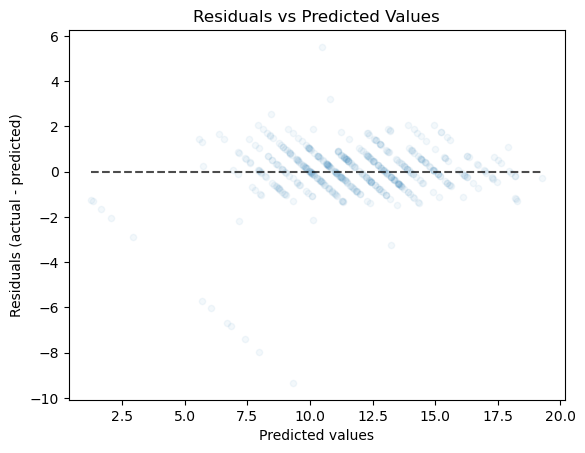

In [26]:
# Fitting the final model
ridge_tuned.fit(X_train, y_train)

# Inspecting the error
PredictionErrorDisplay.from_estimator(
    ridge_tuned,
    X_train,
    y_train,
    scatter_kwargs={'alpha': 0.05, 's': 20},
    subsample=None  # show all predictions
).ax_.set_title('Residuals vs Predicted Values')

Figure 6. Inspecting the model's errors.

Inspecting the errors of our model, it generally falls around the 0 line but only around the range of 8 and up. This tells us that the model does well at predicting grades from 8 but is less reliable on predicting students who get lower grades.

In [27]:
ridge_tuned_coeffs = pd.DataFrame(
    data=ridge_tuned.named_steps['ridge'].coef_,
    index=transformed_student_train.columns,
    columns=['Coefficients']
).sort_values(by='Coefficients', ascending=False)

ridge_tuned_coeffs.style.background_gradient()

,Coefficients
G2,2.045951
G1,0.705004
reason_course,0.231328
higher_yes,0.184885
famsup_yes,0.128762
Fjob_at_home,0.126162
address_U,0.109115
guardian_other,0.107158
Mjob_health,0.088703
traveltime,0.088131


As expected, our largest coefficients for the final model are both G2 and G1 with the rest of the features with significantly lower coefficients. We can see that failures contributes the greatest negatively along with reason = 'other' for choosing the particular school.

In [28]:
# Final scores
preds = ridge_tuned.predict(X_test)

results = pd.DataFrame({
    'MAE': [mean_absolute_error(y_test, preds)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, preds))],
    'R2': [r2_score(y_test, preds)]
})

results

,MAE,RMSE,R2
0,0.775797,1.207309,0.857451


The model generalizes on unseen data well with MAE at 0.776 (lower than CV score) the model is quite precise, only being off by less than a grade point on average. An $R^2$ of 0.857 (higher than CV score) tells us that the model captures majority of the variance in student grade performance.

The model's strong performance is to be expected considering the significant correlation of past grades (`G1` and `G2`) with our target `G3`. Our results can imply that educators can reliably use past performance in order to forecast final grades (i.e. using midterm grades to forecast final grades). The model's performance in predicting students with lower grade outcomes is less reliable and should be met with caution. A more useful but harder to achieve model would be one without `G1` and `G2` features which would be worthwhile to explore.

# References

Cortez, P. (2008). _Student Performance_ [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5TG7T.

Cortez, P. & Silva, A. (2008). Using data mining to predict secondary school student performance. _EUROSIS._ https://doi.org/10.24432/C5TG7T.

Ma, Y., Liu, B., Wong, C., Yu, P., & Lee, S. (2000). Targeting the right students using data mining. _Proceedings of the sixth ACM SIGKDD international conference on Knowledge discovery and data mining,_ 457-464. https://doi.org/10.1145/347090.347184.

Pritchard, M. & Wilson, G. (2003). Using Emotional and Social Factors to Predict Student Success. _Journal of College Student Development,_ 44, 18-28. https://doi.org/10.1353/csd.2003.0008.

Johora, F. T., Hasan, M. N., Rajbongshi, A., Ashrafuzzaman, M., & Akter, F. (2025). An explainable AI-based approach for predicting undergraduate students academic performance. _Array,_ 26, 100384. https://doi.org/10.1016/j.array.2025.100384.
